In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:40707 Dashboard: /proxy/38007/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


Load datasets

In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

ti = '2150-01-01'
tf = '2164-12-31'

In [3]:
ht = cc.querying.getvar(experiment_ryf, 'ht', session_ryf, n = 1).sel(yt_ocean = slice(None, -58))

In [5]:
slev = {}
slev['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session_ryf, start_time = ti, end_time = tf).sel(time = slice(ti, '2169-12-31'), yt_ocean = slice(None, -58))
slev['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['down'] = cc.querying.getvar(experiment_edo, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_zon'] = cc.querying.getvar(easterlies_up_zonal, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_mer'] = cc.querying.getvar(easterlies_up_meridional, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_nDW'] = cc.querying.getvar(easterlies_up_noDSW, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))

# Time series for continental shelf

### Sea level

In [6]:
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [7]:
slev_mask = {}
for k in ['ctrl', 'up', 'down', 'up_zon', 'up_mer', 'up_nDW']:
    slev_mask[k], shelf_mask = shelf_mask_isobath(slev[k])

In [8]:
# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session_ryf, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [9]:
slev_clim_control = ((slev_mask['ctrl']*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month').mean('time')
slev_anom_mask = {}
for k in ['up', 'down', 'up_zon', 'up_mer', 'up_nDW']:
    slev_anom_mask[k] = ((slev_mask[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month') - slev_clim_control

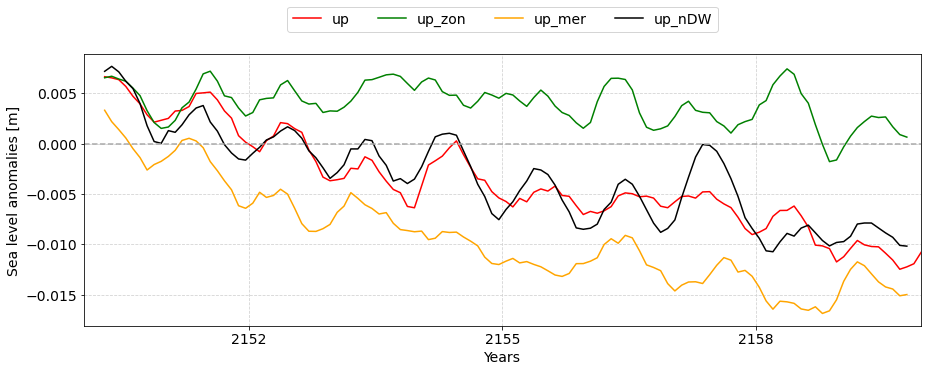

In [17]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 5))
axs = fig.add_subplot()

for k, clr in zip(['up', 'up_zon', 'up_mer', 'up_nDW'], ['r', 'g', 'orange', 'k']):
    axs.plot(slev_anom_mask[k].rolling(time = 6, center = True).mean('time')['time'], 
             slev_anom_mask[k].rolling(time = 6, center = True).mean('time'), color = clr, label = k)

axs.set_xlim(slev_anom_mask['up_zon']['time'][0].values, slev_anom_mask['up_zon']['time'][-1].values)
axs.legend(ncol = 4, loc = 'upper center', bbox_to_anchor = (0.5,1.2))
axs.axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs.grid(linestyle = '--', color = 'lightgrey')
axs.set_ylabel('Sea level anomalies [m]')
axs.set_xlabel('Years')

plt.savefig(figdir+'figure-8-v0.jpg', bbox_inches = 'tight')